<a href="https://colab.research.google.com/github/nelsonalbertohj/Magno-Parvo-CNN/blob/main/Magno_parvo_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install tensorflow_addons

In [13]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import pandas as pd

import keras
import time
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Average
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
print("Tensorflow version: ",tf.__version__)

Tensorflow version:  2.6.0


In [21]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
N_CLASSES = 50
root = f"C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Imagenet-{N_CLASSES}-1500-splits/"
loc = root + "train"
data_dir = pathlib.Path(loc)

batch_size = 32
img_height = 224
img_width = 224

#Training set
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

#Testing set
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 60058 files belonging to 50 classes.
Using 54053 files for training.
Found 60058 files belonging to 50 classes.
Using 6005 files for validation.


In [16]:
def img_transforms(data,label):
    normalize_img = tf.keras.layers.Rescaling(1./255)
    color_norm = normalize_img(data)
    gray_img = tf.image.rgb_to_grayscale(data)
    gray_norm_img = normalize_img(gray_img)
    gray_norm_img = tfa.image.gaussian_filter2d(gray_norm_img,filter_shape=(10,10),sigma=5.0)
    concat_img = tf.concat([color_norm, gray_norm_img],axis=-1)
    return concat_img,label

AUTOTUNE = tf.data.AUTOTUNE

train_ds_preprocessed = train_ds.map(img_transforms)
val_ds_preprocessed = val_ds.map(img_transforms)

#NOTE: THE CASHE ON DISK IS ONLY NECESSARY IF HAVING ISSUES WITH IMAGE LOADING BOTTLENECK
CASHE_Train = fr"C:\Users\nelso\Desktop\9.60 Local Data\CASHE_Train_Blur_{N_CLASSES}_1500"
CASHE_Val = fr"C:\Users\nelso\Desktop\9.60 Local Data\CASHE_Val_Blur_{N_CLASSES}_1500"
train_ds_preprocessed = train_ds_preprocessed.cache(CASHE_Train).prefetch(buffer_size=AUTOTUNE)
val_ds_preprocessed = val_ds_preprocessed.cache(CASHE_Val).prefetch(buffer_size=AUTOTUNE)

In [24]:
# Used to create CASHE in local disk by loading all images
idx = 0
start_time = time.time()
for t in val_ds_preprocessed:
  print("time to get object: ", time.time()-start_time)
  idx += 1
  start_time = time.time()

time to get object:  2.407158374786377
time to get object:  0.061013221740722656
time to get object:  0.32607340812683105
time to get object:  0.048011064529418945
time to get object:  0.049013376235961914
time to get object:  0.07301449775695801
time to get object:  0.05701398849487305
time to get object:  0.0510101318359375
time to get object:  0.04300975799560547
time to get object:  0.04100966453552246
time to get object:  0.11502504348754883
time to get object:  0.06701540946960449
time to get object:  0.04401040077209473
time to get object:  0.048010826110839844
time to get object:  0.06601524353027344
time to get object:  0.2630574703216553
time to get object:  0.10602378845214844
time to get object:  0.22005105018615723
time to get object:  0.0420079231262207
time to get object:  0.365081787109375
time to get object:  0.09402084350585938
time to get object:  0.04100942611694336
time to get object:  0.0490109920501709
time to get object:  0.04201149940490723
time to get object: 

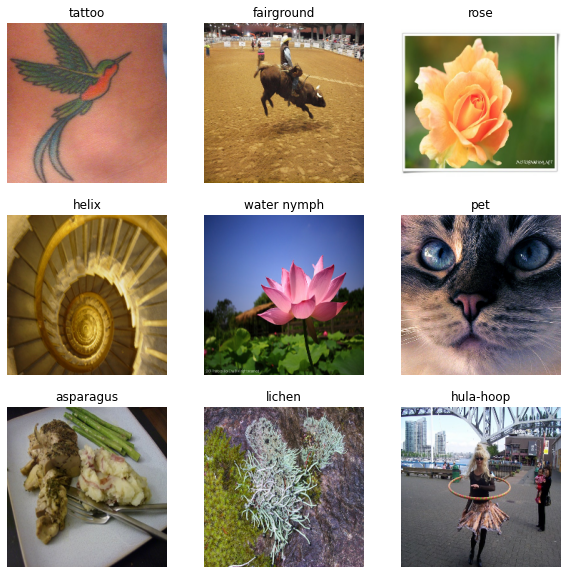

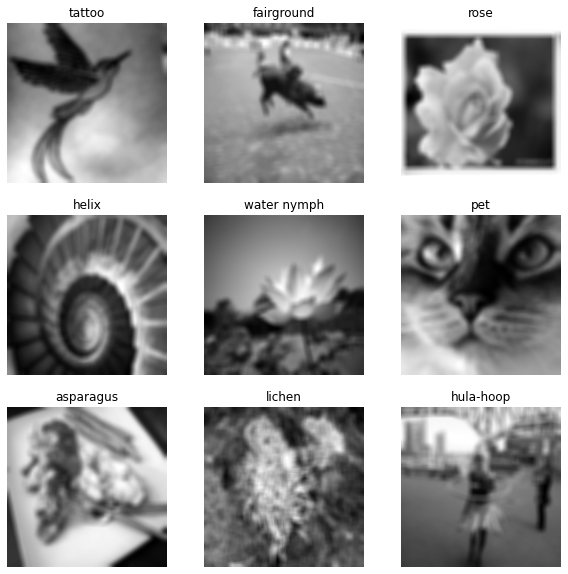

In [25]:
#Need to run to test that the correct image transformations were applied

class_names = train_ds.class_names
gray_imgs = []
plt.figure(figsize=(10, 10))
for images, labels in train_ds_preprocessed.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        current_img = images[i]
        plt.imshow(current_img.numpy()[:,:,:-1])
        gray_imgs.append((current_img,np.argmax(labels[i])))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
plt.figure(figsize=(10, 10))
for images, labels in train_ds_preprocessed.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        current_img = images[i]
        plt.imshow(current_img.numpy()[:,:,-1],cmap="gray")
        gray_imgs.append((current_img,np.argmax(labels[i])))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [ ]:
#Visualizing gray images and other effects

np.random.seed(0)

def img_transforms_no_blur(data,label):
    normalize_img = tf.keras.layers.Rescaling(1./255)
    color_norm = normalize_img(data)
    gray_img = tf.image.rgb_to_grayscale(data)
    gray_norm_img = normalize_img(gray_img)
    concat_img = tf.concat([color_norm, gray_norm_img],axis=-1)
    return concat_img,label

val_ds_preprocessed_no_blur = val_ds.map(img_transforms_no_blur)

class_names = train_ds.class_names
gray_imgs = []
plt.figure(figsize=(10, 10))
for images, labels in val_ds_preprocessed_no_blur.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        current_img = images[i]
        plt.imshow(current_img.numpy()[:,:,-1],cmap="gray")
        gray_imgs.append((current_img,np.argmax(labels[i])))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

plt.figure(figsize=(10, 10))
for i, (images, labels) in enumerate(gray_imgs):
      ax = plt.subplot(3, 3, i + 1)
      blurred_img = tfa.image.gaussian_filter2d(images[:,:,-1:],filter_shape=(10,10),sigma=5.0)
      plt.imshow(blurred_img.numpy().squeeze(),cmap="gray")
      plt.title(class_names[labels])
      plt.axis("off")

### Dual Stream ResNet Architecture

In [ ]:
from keras.backend import dropout
class DualStream_ResNet(tf.keras.Model):
    def __init__(self, n_outputs, batch_size, freeze = True, load_type=None, 
                 merge_type="averaging"):
        super().__init__()
        self.n_outputs =  n_outputs
        self.merge_type = merge_type

        self.parv_stream = tf.keras.applications.ResNet50(
                            include_top=False,
                            weights= load_type,
                            input_tensor=None,
                            input_shape=None,
                            pooling=None,
                            classes=n_outputs,
                            )
        
        self.mag_stream = tf.keras.applications.ResNet50(
                            include_top=False,
                            weights= load_type,
                            input_tensor=None,
                            input_shape=None,
                            pooling=None,
                            classes=n_outputs,
                            )
        if freeze:
          self.parv_stream.trainable = False
          self.mag_stream.trainable = False

        self.flat = tf.keras.layers.Flatten()
        self.fc = Sequential([#tf.keras.layers.Dense(2048,activation='ReLU'),
                              # tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(1280, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(640, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(self.n_outputs, activation='softmax')])
        
        self.avg = tf.keras.layers.Average()
        self.concat = tf.keras.layers.Concatenate()

    def call(self,inputs):
        color_input = inputs[:,:,:,:-1]
        gray_input = inputs[:,:,:,-1:]
        concat_gray_input = tf.concat([gray_input,
                                      gray_input,
                                      gray_input],axis=-1)

        parvo_stream = self.parv_stream(color_input)
        parvo_stream = self.flat(parvo_stream)
        
        magno_stream = self.mag_stream(concat_gray_input)
        magno_stream = self.flat(magno_stream)
        
        if self.merge_type == "averaging":
          avg_outputs = self.avg([magno_stream,parvo_stream])
        elif self.merge_type == "concat":
          avg_outputs = self.concat([magno_stream,parvo_stream])
        else:
          raise "That layer option is not available"
        return self.fc(avg_outputs)

In [ ]:
FREEZE = False 
LOAD_WEIGHTS = None #One of None or imagenet
dual_stream_model = DualStream_ResNet(10,batch_size,FREEZE,load_type=LOAD_WEIGHTS,
                                      merge_type="averaging")
dual_stream_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
model_save_loc = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Models/"
model_name = "Dualstream_with_ResNet_1000_Samples_Deeper_10Classes/"
checkpoint_path = f"{model_save_loc}{model_name}"
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only = True,
                                                 monitor='val_accuracy',
                                                 verbose=1)

train_history = dual_stream_model.fit(train_ds_preprocessed, validation_data= val_ds_preprocessed,
                                      epochs= 60, callbacks=[callback,cp_callback], workers = 4)

# dual_stream_model.save()

#Save training history to CSV
hist_df = pd.DataFrame(train_history.history)

hist_csv_file = f"{model_save_loc}{model_name}_history.csv"
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

plt.figure()
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model_save_loc = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Models/"
model_name = "Dualstream_with_ResNet_1000_Samples_Deeper_10Classes/"
checkpoint_path = f"{model_save_loc}{model_name}"
#Load Model:
dual_stream_model = tf.keras.models.load_model(checkpoint_path)
# eval_loss, eval_accuracy = dual_stream_model.evaluate(val_ds_preprocessed)


### Simple ResNet architectur test

In [ ]:
#Testing Pure ResNet Model Training
from keras.backend import dropout
class Single_ResNet(tf.keras.Model):
    def __init__(self, n_outputs, batch_size, freeze = True, load_type=None, 
                 merge_type="averaging"):
        super().__init__()
        self.n_outputs =  n_outputs
        self.merge_type = merge_type

        self.parv_stream = tf.keras.applications.ResNet50(
                            include_top=False,
                            weights= load_type,
                            input_tensor=None,
                            input_shape=None,
                            pooling=None,
                            classes=n_outputs,
                            )
        if freeze:
          self.parv_stream.trainable = False

        self.flat = tf.keras.layers.Flatten()
        self.fc = Sequential([#tf.keras.layers.Dense(2048,activation='ReLU'),
                              #tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(1280, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(640, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(self.n_outputs, activation='softmax')])
        
        self.avg = tf.keras.layers.Average()
        self.concat = tf.keras.layers.Concatenate()

    def call(self,inputs):
        color_input = inputs[:,:,:,:-1]

        parvo_stream = self.parv_stream(color_input)
        parvo_stream = self.flat(parvo_stream)

        return self.fc(parvo_stream)

In [ ]:
FREEZE = False 
LOAD_WEIGHTS = None #One of None or imagenet
signle_resnet_model = Single_ResNet(10,batch_size,FREEZE,load_type=LOAD_WEIGHTS,
                                      merge_type="averaging")
signle_resnet_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

train_history = signle_resnet_model.fit(train_ds_preprocessed, validation_data= val_ds_preprocessed,
                                      epochs= 30, callbacks=callback, workers = 4)
signle_resnet_model.save("/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Models/Single_ResNet_1000_Samples_Deeper")

Epoch 1/30
291/291 [==============================] - 72s 227ms/step - loss: 13.6862 - accuracy: 0.1110 - val_loss: 2.3041 - val_accuracy: 0.1156
Epoch 2/30
291/291 [==============================] - 64s 219ms/step - loss: 2.2606 - accuracy: 0.1448 - val_loss: 2.2146 - val_accuracy: 0.1586
Epoch 3/30
291/291 [==============================] - 64s 219ms/step - loss: 2.2257 - accuracy: 0.1625 - val_loss: 2.1758 - val_accuracy: 0.1844
Epoch 4/30
291/291 [==============================] - 63s 216ms/step - loss: 2.1793 - accuracy: 0.1795 - val_loss: 2.1855 - val_accuracy: 0.1624
Epoch 5/30
291/291 [==============================] - 64s 220ms/step - loss: 2.1579 - accuracy: 0.1872 - val_loss: 2.0857 - val_accuracy: 0.1990
Epoch 6/30
291/291 [==============================] - 64s 220ms/step - loss: 2.1143 - accuracy: 0.2057 - val_loss: 2.0430 - val_accuracy: 0.2119
Epoch 7/30
291/291 [==============================] - 64s 219ms/step - loss: 2.0276 - accuracy: 0.2475 - val_loss: 1.8438 - val_a

INFO:tensorflow:Assets written to: /content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Models/Single_ResNet_1000_Samples_Deeper/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Models/Single_ResNet_1000_Samples_Deeper/assets


### Dual Stream CNN Net
Implemented AlexNet-like neural net. It has easier training procedure and more meaningful Magno and Parvo implementations

In [38]:
class DualStream_CNN(tf.keras.Model):
    def __init__(self, n_outputs, batch_size, load_type="imagenet", merge_type="averaging"):
        super().__init__()
        self.n_outputs =  n_outputs
        self.merge_type = merge_type

        self.parv_stream = keras.models.Sequential([
        keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))])
        # keras.layers.Flatten()])
        
        self.mag_stream = keras.models.Sequential([
        keras.layers.Conv2D(filters=96, kernel_size=(13,13), strides=(4,4), activation='relu', input_shape=(224,224,3)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=256, kernel_size=(7,7), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=384, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))])
        # keras.layers.Flatten()])

        self.flat = tf.keras.layers.Flatten()
        self.fc = Sequential([tf.keras.layers.Dense(2048,activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(1280, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(640, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(self.n_outputs, activation='softmax')])
        
        self.avg = tf.keras.layers.Average()
        self.concat = tf.keras.layers.Concatenate()

    def call(self,inputs):
        color_input = inputs[:,:,:,:-1]
        gray_input = inputs[:,:,:,-1:]
        concat_gray_input = tf.concat([gray_input,
                                      gray_input,
                                      gray_input],axis=-1)

        parvo_stream = self.parv_stream(color_input)
        parvo_stream = self.flat(parvo_stream)
        
        magno_stream = self.mag_stream(concat_gray_input)
        magno_stream = self.flat(magno_stream)
        
        if self.merge_type == "averaging":
          avg_outputs = self.avg([magno_stream,parvo_stream])
        elif self.merge_type == "concat":
          avg_outputs = self.concat([magno_stream,parvo_stream])
        else:
          raise "That layer option is not available"
        return self.fc(avg_outputs)

In [41]:
dual_stream_model = DualStream_CNN(N_CLASSES,batch_size, load_type=None, merge_type="averaging")
dual_stream_model.compile(loss = 'categorical_crossentropy', optimizer = tf.optimizers.Adam(
                          learning_rate=0.001), metrics = ['accuracy'])

In [44]:
model_save_loc = "C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models/"
model_name = f"Dualstream_with_CNN_1000_Samples_{N_CLASSES}Classes_Deeper_Version2"
checkpoint_path = f"{model_save_loc}{model_name}"
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only = True,
                                                 monitor='val_accuracy',
                                                 verbose=1)

train_history = dual_stream_model.fit(train_ds_preprocessed, validation_data= val_ds_preprocessed,
                                      epochs= 60, callbacks=[callback,cp_callback], workers = 4)

# dual_stream_model.save()

#Save training history to CSV
hist_df = pd.DataFrame(train_history.history)

hist_csv_file = f"{model_save_loc}{model_name}_history.csv"
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

plt.figure()
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/60
1690/1690 [==============================] - 181s 107ms/step - loss: 1.4772 - accuracy: 0.5646 - val_loss: 2.8567 - val_accuracy: 0.4758

Epoch 00001: val_accuracy improved from -inf to 0.47577, saving model to C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Dualstream_with_CNN_1000_Samples_50Classes_Deeper_Version2


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Dualstream_with_CNN_1000_Samples_50Classes_Deeper_Version2\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Dualstream_with_CNN_1000_Samples_50Classes_Deeper_Version2\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/60
1690/1690 [==============================] - 183s 108ms/step - loss: 1.3899 - accuracy: 0.5828 - val_loss: 3.1584 - val_accuracy: 0.4616

Epoch 00002: val_accuracy did not improve from 0.47577
Epoch 3/60
1690/1690 [==============================] - 183s 108ms/step - loss: 1.4220 - accuracy: 0.5785 - val_loss: 2.4855 - val_accuracy: 0.4979

Epoch 00003: val_accuracy improved from 0.47577 to 0.49792, saving model to C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Dualstream_with_CNN_1000_Samples_50Classes_Deeper_Version2


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Dualstream_with_CNN_1000_Samples_50Classes_Deeper_Version2\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Dualstream_with_CNN_1000_Samples_50Classes_Deeper_Version2\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/60
1690/1690 [==============================] - 183s 108ms/step - loss: 1.4250 - accuracy: 0.5789 - val_loss: 4.1199 - val_accuracy: 0.4122

Epoch 00004: val_accuracy did not improve from 0.49792
Epoch 5/60
1690/1690 [==============================] - 183s 108ms/step - loss: 1.3988 - accuracy: 0.5828 - val_loss: 3.1300 - val_accuracy: 0.4714

Epoch 00005: val_accuracy did not improve from 0.49792
Epoch 6/60
1690/1690 [==============================] - 184s 109ms/step - loss: 1.3934 - accuracy: 0.5848 - val_loss: 3.8527 - val_accuracy: 0.4556

Epoch 00006: val_accuracy did not improve from 0.49792
Epoch 7/60
1690/1690 [==============================] - 186s 110ms/step - loss: 1.4786 - accuracy: 0.5708 - val_loss: 2.8259 - val_accuracy: 0.4721

Epoch 00007: val_accuracy did not improve from 0.49792
Epoch 8/60
1690/1690 [==============================] - 187s 110ms/step - loss: 1.4150 - accuracy: 0.5806 - val_loss: 2.5482 - val_accuracy: 0.4545

Epoch 00008: val_accuracy did not i

INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Dualstream_with_CNN_1000_Samples_50Classes_Deeper_Version2\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Dualstream_with_CNN_1000_Samples_50Classes_Deeper_Version2\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 20/60
1690/1690 [==============================] - 186s 110ms/step - loss: 1.2766 - accuracy: 0.6160 - val_loss: 4.4516 - val_accuracy: 0.4518

Epoch 00020: val_accuracy did not improve from 0.50325
Epoch 21/60
1690/1690 [==============================] - 186s 110ms/step - loss: 1.2495 - accuracy: 0.6225 - val_loss: 3.2409 - val_accuracy: 0.5042

Epoch 00021: val_accuracy improved from 0.50325 to 0.50425, saving model to C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Dualstream_with_CNN_1000_Samples_50Classes_Deeper_Version2


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Dualstream_with_CNN_1000_Samples_50Classes_Deeper_Version2\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Dualstream_with_CNN_1000_Samples_50Classes_Deeper_Version2\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 22/60
1690/1690 [==============================] - 186s 110ms/step - loss: 1.3711 - accuracy: 0.6008 - val_loss: 2.5430 - val_accuracy: 0.4643

Epoch 00022: val_accuracy did not improve from 0.50425
Epoch 23/60
1690/1690 [==============================] - 186s 110ms/step - loss: 1.3575 - accuracy: 0.5997 - val_loss: 2.5655 - val_accuracy: 0.4749

Epoch 00023: val_accuracy did not improve from 0.50425
Epoch 24/60
1690/1690 [==============================] - 186s 110ms/step - loss: 1.1969 - accuracy: 0.6327 - val_loss: 6.8748 - val_accuracy: 0.4015

Epoch 00024: val_accuracy did not improve from 0.50425
Epoch 25/60
1690/1690 [==============================] - 186s 110ms/step - loss: 1.2798 - accuracy: 0.6195 - val_loss: 4.1478 - val_accuracy: 0.4879

Epoch 00025: val_accuracy did not improve from 0.50425
Epoch 26/60
1690/1690 [==============================] - 186s 110ms/step - loss: 1.3140 - accuracy: 0.6132 - val_loss: 7.3413 - val_accuracy: 0.4873

Epoch 00026: val_accuracy did 

INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Dualstream_with_CNN_1000_Samples_50Classes_Deeper_Version2\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Dualstream_with_CNN_1000_Samples_50Classes_Deeper_Version2\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 41/60
1690/1690 [==============================] - 184s 109ms/step - loss: 1.2696 - accuracy: 0.6326 - val_loss: 4.5128 - val_accuracy: 0.4799

Epoch 00041: val_accuracy did not improve from 0.50924
Epoch 42/60
1690/1690 [==============================] - 183s 109ms/step - loss: 1.1396 - accuracy: 0.6542 - val_loss: 2.9457 - val_accuracy: 0.4781

Epoch 00042: val_accuracy did not improve from 0.50924
Epoch 43/60
1690/1690 [==============================] - 184s 109ms/step - loss: 1.3379 - accuracy: 0.6197 - val_loss: 5.1256 - val_accuracy: 0.3858

Epoch 00043: val_accuracy did not improve from 0.50924
Epoch 44/60
1690/1690 [==============================] - 184s 109ms/step - loss: 1.2618 - accuracy: 0.6253 - val_loss: 2.7193 - val_accuracy: 0.4764

Epoch 00044: val_accuracy did not improve from 0.50924
Epoch 45/60
1690/1690 [==============================] - 185s 109ms/step - loss: 1.1805 - accuracy: 0.6446 - val_loss: 5.1078 - val_accuracy: 0.4628

Epoch 00045: val_accuracy did 

KeyboardInterrupt: 

In [31]:
model_save_loc = "/content/drive/MyDrive/Vision Dataset/Models/"
model_name = "Dualstream_with_VGG_1000_Samples_10Classes"
checkpoint_path = f"{model_save_loc}{model_name}"

dual_stream_model = tf.keras.models.load_model(checkpoint_path)

In [46]:
class DualFullRes_CNN(tf.keras.Model):
    def __init__(self, n_outputs, batch_size, load_type="imagenet", merge_type="averaging"):
        super().__init__()
        self.n_outputs =  n_outputs
        self.merge_type = merge_type

        self.parv_stream1 = keras.models.Sequential([
        keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))])
        
        self.parv_stream2 = keras.models.Sequential([
        keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))])

        self.flat = tf.keras.layers.Flatten()
        self.fc = Sequential([tf.keras.layers.Dense(2048,activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(1280, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(640, activation='ReLU'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(self.n_outputs, activation='softmax')])
        
        self.avg = tf.keras.layers.Average()
        self.concat = tf.keras.layers.Concatenate()

    def call(self,inputs):
        color_input = inputs[:,:,:,:-1]

        parv1_stream = self.parv_stream1(color_input)
        parv1_stream = self.flat(parv1_stream)
        
        parv2_stream = self.parv_stream2(color_input)
        parv2_stream = self.flat(parv2_stream)
        
        if self.merge_type == "averaging":
          avg_outputs = self.avg([parv2_stream,parv1_stream])
        elif self.merge_type == "concat":
          avg_outputs = self.concat([parv2_stream,parv1_stream])
        else:
          raise "That layer option is not available"
        return self.fc(avg_outputs)

Epoch 1/60
1690/1690 [==============================] - 120s 68ms/step - loss: 3.9018 - accuracy: 0.0572 - val_loss: 3.7718 - val_accuracy: 0.0486

Epoch 00001: val_accuracy improved from -inf to 0.04863, saving model to C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/60
1690/1690 [==============================] - 115s 68ms/step - loss: 3.5318 - accuracy: 0.0903 - val_loss: 3.3034 - val_accuracy: 0.1449

Epoch 00002: val_accuracy improved from 0.04863 to 0.14488, saving model to C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/60
1690/1690 [==============================] - 116s 69ms/step - loss: 3.4385 - accuracy: 0.1049 - val_loss: 3.2158 - val_accuracy: 0.1565

Epoch 00003: val_accuracy improved from 0.14488 to 0.15654, saving model to C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/60
1690/1690 [==============================] - 115s 68ms/step - loss: 3.3434 - accuracy: 0.1195 - val_loss: 3.3313 - val_accuracy: 0.1284

Epoch 00004: val_accuracy did not improve from 0.15654
Epoch 5/60
1690/1690 [==============================] - 115s 68ms/step - loss: 3.2847 - accuracy: 0.1314 - val_loss: 3.2006 - val_accuracy: 0.1592

Epoch 00005: val_accuracy improved from 0.15654 to 0.15920, saving model to C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/60
1690/1690 [==============================] - 115s 68ms/step - loss: 3.2023 - accuracy: 0.1464 - val_loss: 3.0637 - val_accuracy: 0.1882

Epoch 00006: val_accuracy improved from 0.15920 to 0.18818, saving model to C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/60
1690/1690 [==============================] - 115s 68ms/step - loss: 3.1501 - accuracy: 0.1565 - val_loss: 2.9734 - val_accuracy: 0.2067

Epoch 00007: val_accuracy improved from 0.18818 to 0.20666, saving model to C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/60
1690/1690 [==============================] - 115s 68ms/step - loss: 3.0785 - accuracy: 0.1744 - val_loss: 3.1812 - val_accuracy: 0.1469

Epoch 00008: val_accuracy did not improve from 0.20666
Epoch 9/60
1690/1690 [==============================] - 115s 68ms/step - loss: 3.0215 - accuracy: 0.1862 - val_loss: 2.7698 - val_accuracy: 0.2545

Epoch 00009: val_accuracy improved from 0.20666 to 0.25445, saving model to C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 10/60
1690/1690 [==============================] - 115s 68ms/step - loss: 2.9642 - accuracy: 0.1995 - val_loss: 2.7661 - val_accuracy: 0.2560

Epoch 00010: val_accuracy improved from 0.25445 to 0.25595, saving model to C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/60
1690/1690 [==============================] - 115s 68ms/step - loss: 2.9006 - accuracy: 0.2170 - val_loss: 2.7872 - val_accuracy: 0.2466

Epoch 00011: val_accuracy did not improve from 0.25595
Epoch 12/60
1690/1690 [==============================] - 115s 68ms/step - loss: 2.8345 - accuracy: 0.2291 - val_loss: 2.7105 - val_accuracy: 0.2733

Epoch 00012: val_accuracy improved from 0.25595 to 0.27327, saving model to C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/60
1690/1690 [==============================] - 115s 68ms/step - loss: 2.7781 - accuracy: 0.2439 - val_loss: 2.6343 - val_accuracy: 0.2909

Epoch 00013: val_accuracy improved from 0.27327 to 0.29092, saving model to C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 14/60
1690/1690 [==============================] - 115s 68ms/step - loss: 2.7208 - accuracy: 0.2566 - val_loss: 2.9341 - val_accuracy: 0.2340

Epoch 00014: val_accuracy did not improve from 0.29092
Epoch 15/60
1690/1690 [==============================] - 115s 68ms/step - loss: 2.6637 - accuracy: 0.2714 - val_loss: 2.6023 - val_accuracy: 0.2881

Epoch 00015: val_accuracy did not improve from 0.29092
Epoch 16/60
1690/1690 [==============================] - 115s 68ms/step - loss: 2.5983 - accuracy: 0.2851 - val_loss: 2.5863 - val_accuracy: 0.3016

Epoch 00016: val_accuracy improved from 0.29092 to 0.30158, saving model to C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 17/60
1690/1690 [==============================] - 115s 68ms/step - loss: 2.5440 - accuracy: 0.3009 - val_loss: 2.3807 - val_accuracy: 0.3564

Epoch 00017: val_accuracy improved from 0.30158 to 0.35637, saving model to C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 18/60
1690/1690 [==============================] - 115s 68ms/step - loss: 2.5018 - accuracy: 0.3127 - val_loss: 2.5171 - val_accuracy: 0.3134

Epoch 00018: val_accuracy did not improve from 0.35637
Epoch 19/60
1690/1690 [==============================] - 115s 68ms/step - loss: 2.4468 - accuracy: 0.3250 - val_loss: 2.3131 - val_accuracy: 0.3560

Epoch 00019: val_accuracy did not improve from 0.35637
Epoch 20/60
1690/1690 [==============================] - 115s 68ms/step - loss: 2.3946 - accuracy: 0.3363 - val_loss: 2.5008 - val_accuracy: 0.3186

Epoch 00020: val_accuracy did not improve from 0.35637
Epoch 21/60
1690/1690 [==============================] - 115s 68ms/step - loss: 2.3587 - accuracy: 0.3454 - val_loss: 2.5404 - val_accuracy: 0.3412

Epoch 00021: val_accuracy did not improve from 0.35637
Epoch 22/60
1690/1690 [==============================] - 115s 68ms/step - loss: 2.3202 - accuracy: 0.3556 - val_loss: 2.3537 - val_accuracy: 0.3714

Epoch 00022: val_accuracy improved 

INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 23/60
1690/1690 [==============================] - 115s 68ms/step - loss: 2.2673 - accuracy: 0.3695 - val_loss: 2.4093 - val_accuracy: 0.3580

Epoch 00023: val_accuracy did not improve from 0.37136
Epoch 24/60
1690/1690 [==============================] - 115s 68ms/step - loss: 2.2134 - accuracy: 0.3835 - val_loss: 2.2931 - val_accuracy: 0.3737

Epoch 00024: val_accuracy improved from 0.37136 to 0.37369, saving model to C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 25/60
1690/1690 [==============================] - 115s 68ms/step - loss: 2.1903 - accuracy: 0.3898 - val_loss: 2.1392 - val_accuracy: 0.4073

Epoch 00025: val_accuracy improved from 0.37369 to 0.40733, saving model to C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 26/60
1690/1690 [==============================] - 115s 68ms/step - loss: 2.1367 - accuracy: 0.4026 - val_loss: 3.2013 - val_accuracy: 0.2355

Epoch 00026: val_accuracy did not improve from 0.40733
Epoch 27/60
1690/1690 [==============================] - 115s 68ms/step - loss: 2.1075 - accuracy: 0.4104 - val_loss: 2.7529 - val_accuracy: 0.3082

Epoch 00027: val_accuracy did not improve from 0.40733
Epoch 28/60
1690/1690 [==============================] - 115s 68ms/step - loss: 2.0766 - accuracy: 0.4212 - val_loss: 2.2747 - val_accuracy: 0.3905

Epoch 00028: val_accuracy did not improve from 0.40733
Epoch 29/60
1690/1690 [==============================] - 115s 68ms/step - loss: 2.0317 - accuracy: 0.4273 - val_loss: 2.2558 - val_accuracy: 0.4003

Epoch 00029: val_accuracy did not improve from 0.40733
Epoch 30/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.9972 - accuracy: 0.4365 - val_loss: 2.4841 - val_accuracy: 0.3331

Epoch 00030: val_accuracy did not i

INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 33/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.8874 - accuracy: 0.4612 - val_loss: 2.3487 - val_accuracy: 0.3973

Epoch 00033: val_accuracy did not improve from 0.43547
Epoch 34/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.8661 - accuracy: 0.4680 - val_loss: 2.0750 - val_accuracy: 0.4285

Epoch 00034: val_accuracy did not improve from 0.43547
Epoch 35/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.8517 - accuracy: 0.4711 - val_loss: 2.1664 - val_accuracy: 0.4220

Epoch 00035: val_accuracy did not improve from 0.43547
Epoch 36/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.8190 - accuracy: 0.4793 - val_loss: 2.0851 - val_accuracy: 0.4423

Epoch 00036: val_accuracy improved from 0.43547 to 0.44230, saving model to C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 37/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.7851 - accuracy: 0.4876 - val_loss: 2.4070 - val_accuracy: 0.4125

Epoch 00037: val_accuracy did not improve from 0.44230
Epoch 38/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.7903 - accuracy: 0.4866 - val_loss: 2.5742 - val_accuracy: 0.3892

Epoch 00038: val_accuracy did not improve from 0.44230
Epoch 39/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.7365 - accuracy: 0.4991 - val_loss: 2.5901 - val_accuracy: 0.3878

Epoch 00039: val_accuracy did not improve from 0.44230
Epoch 40/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.7068 - accuracy: 0.5067 - val_loss: 1.9514 - val_accuracy: 0.4759

Epoch 00040: val_accuracy improved from 0.44230 to 0.47594, saving model to C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 41/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.6904 - accuracy: 0.5109 - val_loss: 2.3057 - val_accuracy: 0.4286

Epoch 00041: val_accuracy did not improve from 0.47594
Epoch 42/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.7358 - accuracy: 0.5043 - val_loss: 2.1971 - val_accuracy: 0.4495

Epoch 00042: val_accuracy did not improve from 0.47594
Epoch 43/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.6562 - accuracy: 0.5228 - val_loss: 1.9390 - val_accuracy: 0.4808

Epoch 00043: val_accuracy improved from 0.47594 to 0.48077, saving model to C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 44/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.6267 - accuracy: 0.5247 - val_loss: 2.0596 - val_accuracy: 0.4693

Epoch 00044: val_accuracy did not improve from 0.48077
Epoch 45/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.6235 - accuracy: 0.5289 - val_loss: 2.3794 - val_accuracy: 0.3823

Epoch 00045: val_accuracy did not improve from 0.48077
Epoch 46/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.5809 - accuracy: 0.5362 - val_loss: 2.0337 - val_accuracy: 0.4749

Epoch 00046: val_accuracy did not improve from 0.48077
Epoch 47/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.5841 - accuracy: 0.5390 - val_loss: 1.9651 - val_accuracy: 0.4964

Epoch 00047: val_accuracy improved from 0.48077 to 0.49642, saving model to C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 48/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.5935 - accuracy: 0.5383 - val_loss: 2.1193 - val_accuracy: 0.4811

Epoch 00048: val_accuracy did not improve from 0.49642
Epoch 49/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.5412 - accuracy: 0.5475 - val_loss: 2.3802 - val_accuracy: 0.4498

Epoch 00049: val_accuracy did not improve from 0.49642
Epoch 50/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.5551 - accuracy: 0.5470 - val_loss: 2.1989 - val_accuracy: 0.4719

Epoch 00050: val_accuracy did not improve from 0.49642
Epoch 51/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.4916 - accuracy: 0.5586 - val_loss: 2.1447 - val_accuracy: 0.4713

Epoch 00051: val_accuracy did not improve from 0.49642
Epoch 52/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.5056 - accuracy: 0.5593 - val_loss: 2.7170 - val_accuracy: 0.3504

Epoch 00052: val_accuracy did not i

INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 54/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.4455 - accuracy: 0.5753 - val_loss: 2.1561 - val_accuracy: 0.4653

Epoch 00054: val_accuracy did not improve from 0.49892
Epoch 55/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.4957 - accuracy: 0.5625 - val_loss: 2.3072 - val_accuracy: 0.4490

Epoch 00055: val_accuracy did not improve from 0.49892
Epoch 56/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.3980 - accuracy: 0.5831 - val_loss: 2.1701 - val_accuracy: 0.5096

Epoch 00056: val_accuracy improved from 0.49892 to 0.50958, saving model to C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets


INFO:tensorflow:Assets written to: C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models\Parallel_with_CNN_1000_Samples_50Classes_Deeper\assets
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 57/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.4895 - accuracy: 0.5686 - val_loss: 1.9856 - val_accuracy: 0.5077

Epoch 00057: val_accuracy did not improve from 0.50958
Epoch 58/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.4085 - accuracy: 0.5818 - val_loss: 2.2763 - val_accuracy: 0.4545

Epoch 00058: val_accuracy did not improve from 0.50958
Epoch 59/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.3825 - accuracy: 0.5886 - val_loss: 2.3832 - val_accuracy: 0.3992

Epoch 00059: val_accuracy did not improve from 0.50958
Epoch 60/60
1690/1690 [==============================] - 115s 68ms/step - loss: 1.5435 - accuracy: 0.5604 - val_loss: 2.0813 - val_accuracy: 0.4766

Epoch 00060: val_accuracy did not improve from 0.50958


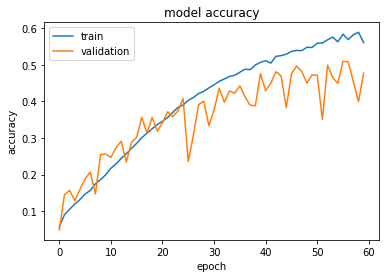

In [47]:
dual_stream_model = DualFullRes_CNN(N_CLASSES,batch_size, load_type=None, merge_type="averaging")
dual_stream_model.compile(loss = 'categorical_crossentropy', optimizer = tf.optimizers.Adam(
                          learning_rate=0.001), metrics = ['accuracy'])

model_save_loc = "C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset/Models/"
model_name = f"Parallel_with_CNN_1000_Samples_{N_CLASSES}Classes_Deeper"
checkpoint_path = f"{model_save_loc}{model_name}"
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only = True,
                                                 monitor='val_accuracy',
                                                 verbose=1)

train_history = dual_stream_model.fit(train_ds_preprocessed, validation_data= val_ds_preprocessed,
                                      epochs= 60, callbacks=[callback,cp_callback], workers = 4)

# dual_stream_model.save()

#Save training history to CSV
hist_df = pd.DataFrame(train_history.history)

hist_csv_file = f"{model_save_loc}{model_name}_history.csv"
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

plt.figure()
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()